In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse

from read_db.read_clickhouse import connection


def get_exp_data(exp_dt_from, exp_dt_to, control_id, treat_id):
    
    q = f"""SELECT 
        exp_group, user_id,
        sum(action='like') likes,
        sum(action='view') views,
        likes/views ctr
        
       FROM {connection['database']}.feed_actions 
       where toDate(time) between '{exp_dt_from}' and '{exp_dt_to}' 
       and exp_group in ({control_id},{treat_id}) 
       group by exp_group, user_id

       """
    df = pandahouse.read_clickhouse(q, connection=connection)
    return df

def stest(data, column, control_id, treat_id, method = stats.mannwhitneyu, **kwargs):
    control = data.query(f"exp_group=={control_id}")[column].values
    treat = data.query(f"exp_group=={treat_id}")[column].values

    print(method(control,treat, **kwargs, ))
    



# Сравнение групп 0 и 3

ctr контрольной группы 0.20823612262916305


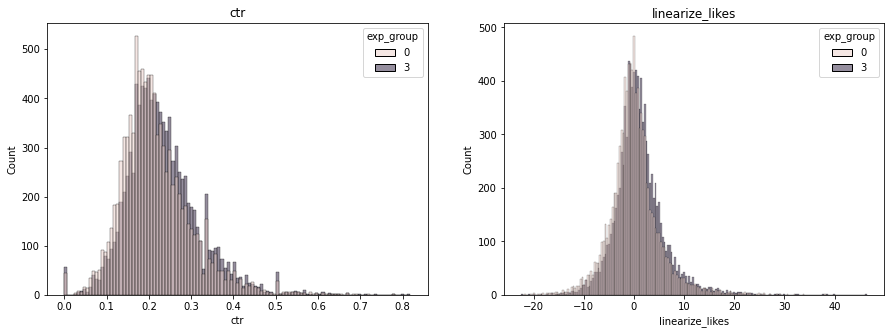

In [2]:
#читаем данные из бд
control_id =0
treat_id = 3
df = get_exp_data('2022-11-02', '2022-11-08', control_id, treat_id)

control_df =df[df.exp_group == control_id]
ctr_control = control_df.likes.sum()/control_df.views.sum()
print('ctr контрольной группы', ctr_control)

df['linearize_likes'] = df.likes - ctr_control*df.views

# посмотрим на распредление CTR по группам

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].set_title('ctr')
sns.histplot(x='ctr', data=df, hue='exp_group', ax=ax[0])

#распределение linearize_likes
ax[1].set_title('linearize_likes')
sns.histplot(x='linearize_likes', data=df, hue='exp_group', ax=ax[1])

plt.show()


In [3]:
print('Пользовательские ctr:')
stest(df, 'ctr', control_id, treat_id, method= stats.ttest_ind, equal_var=False)

Пользовательские ctr:
Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)


In [4]:
print('linearize_likes:')
stest(df,  'linearize_likes', control_id, treat_id, method= stats.ttest_ind, equal_var=False)

linearize_likes:
Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)


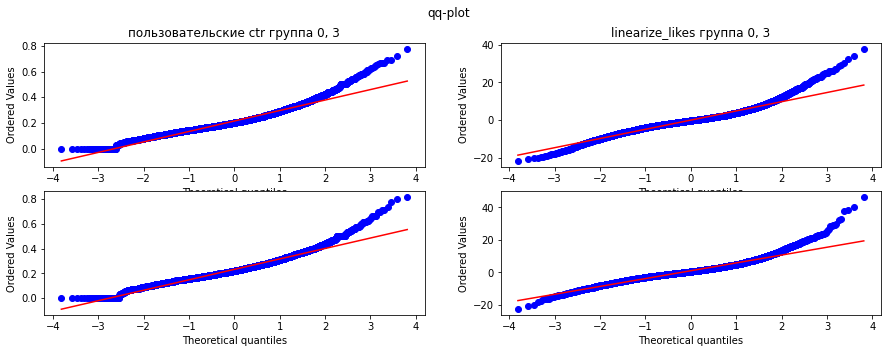

In [5]:
fig, ax = plt.subplots(2,2, figsize=(15,5))


stats.probplot(df.query(f"exp_group=={control_id}")['ctr'].values, plot=ax[0,0])
stats.probplot(df.query(f"exp_group=={treat_id}")['ctr'].values, plot=ax[1,0])

stats.probplot(df.query(f"exp_group=={control_id}")['linearize_likes'].values, plot=ax[0,1])
stats.probplot(df.query(f"exp_group=={treat_id}")['linearize_likes'].values, plot=ax[1,1])

fig.suptitle('qq-plot')
ax[0,0].set_title('пользовательские ctr группа 0, 3')
ax[1,0].set_title('')
ax[0,1].set_title('linearize_likes группа 0, 3')
ax[1,1].set_title('')
plt.show()

## Вывод

p-value теста на linearize_likes уменьшилось. Распеределение стало немного нормальнее

# Группы 1,3

ctr контрольной группы 0.20802680490126244


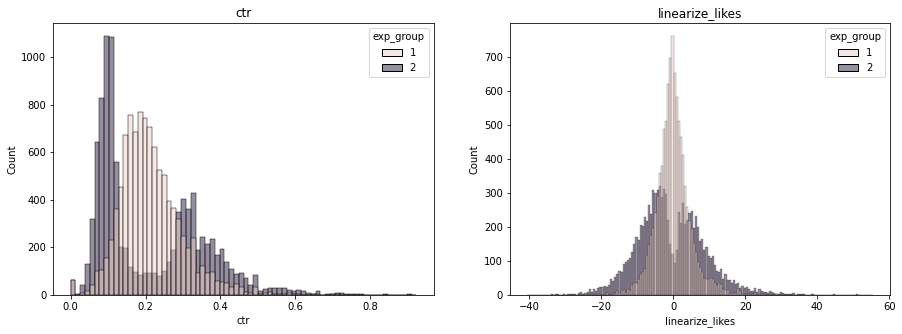

In [6]:
#читаем данные из бд
control_id =1
treat_id = 2
df = get_exp_data('2022-11-02', '2022-11-08', control_id, treat_id)

control_df =df[df.exp_group == control_id]
ctr_control = control_df.likes.sum()/control_df.views.sum()
print('ctr контрольной группы', ctr_control)

df['linearize_likes'] = df.likes - ctr_control*df.views

# посмотрим на распредление CTR по группам

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].set_title('ctr')
sns.histplot(x='ctr', data=df, hue='exp_group', ax=ax[0])

#распределение linearize_likes
ax[1].set_title('linearize_likes')
sns.histplot(x='linearize_likes', data=df, hue='exp_group', ax=ax[1])

plt.show()


In [7]:
print('Пользовательские ctr:')
stest(df, 'ctr', control_id, treat_id, method= stats.ttest_ind, equal_var=False)

Пользовательские ctr:
Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)


In [8]:
print('linearize_likes:')
stest(df,  'linearize_likes', control_id, treat_id, method= stats.ttest_ind, equal_var=False)

linearize_likes:
Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)


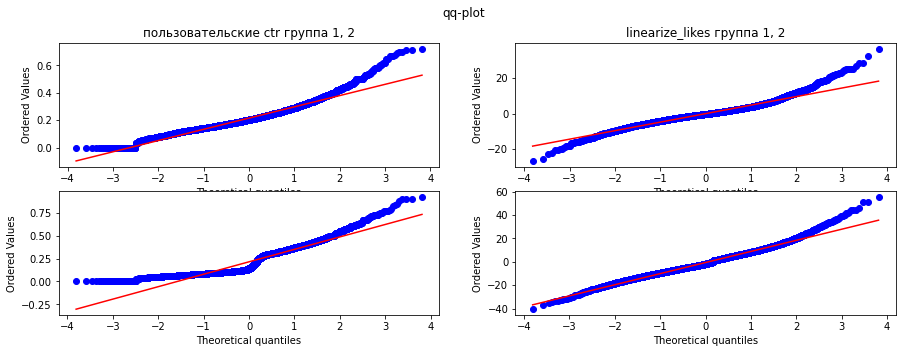

In [9]:
fig, ax = plt.subplots(2,2, figsize=(15,5))

x = stats.norm.rvs(loc=5, scale=3, size=100)
stats.probplot(df.query(f"exp_group=={control_id}")['ctr'].values, plot=ax[0,0])
stats.probplot(df.query(f"exp_group=={treat_id}")['ctr'].values, plot=ax[1,0])

stats.probplot(df.query(f"exp_group=={control_id}")['linearize_likes'].values, plot=ax[0,1])
stats.probplot(df.query(f"exp_group=={treat_id}")['linearize_likes'].values, plot=ax[1,1])

fig.suptitle('qq-plot')
ax[0,0].set_title('пользовательские ctr группа 1, 2')
ax[1,0].set_title('')
ax[0,1].set_title('linearize_likes группа 1, 2')
ax[1,1].set_title('')
plt.show()

## Вывод

p-value теста на linearize_likes уменьшилось. Распеределения стали нормальнее, но для группы 2 все равно наблюдается бимодальность.

t-тест на linearize_likes показал статистически значимые различия, в отличии от t-testa на поюзерных ctr

